In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils import resample

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

np.random.seed(42)

%matplotlib inline

In [2]:
def remove_au_features(df, au_list):
    for au in au_list:
        df.drop([f'AU{au}_std', f'AU{au}_mean', f'AU{au}_e0_length', f'AU{au}_e1_length', f'AU{au}_e2_length',
                f'AU{au}_e0_amount', f'AU{au}_e1_amount', f'AU{au}_e2_amount',
                f'AU{au}_e0_intensity', f'AU{au}_e1_intensity', f'AU{au}_e2_intensity'], axis=1, inplace=True)


def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]


def over_sample(df, label_='happy', amount=95):
    df_happy = df[df.label == label_]
    df_happy = resample(df_happy,
                        replace=True,     # sample with replacement
                        n_samples=amount,    # to match majority class
                        random_state=42) # reproducible results

    return pd.concat([df, df_happy])


def fix_label_name(df):
    for emotion in ['happy', 'angry', 'neutral', 'sad']:
        df = df.replace(f'{emotion}.csv', emotion)
    return df

In [3]:
df = pd.read_csv('../feature_vector.csv', index_col=0)
# df = fix_label_name(df)
# df = df[df['group'] == 'coda_speak'] #'hearing', 'C', D

df = df.replace('coda_speech', 'speaking')
df = df.replace('hear', 'speaking')
df = df.replace('coda_sign', 'signing')
df = df.replace('deaf', 'signing')

# df = df.replace('angry', 'angry_sad')
# df = df.replace('sad', 'angry_sad')


#Over sample
# df = over_sample(df, 'happy', 336-169)
# df = over_sample(df, 'neutral', 336-169)


label_names = ['sad', 'neutral'] #['angry','happy', 'neutral', 'sad'] #['neutral', 'angry']
df = subsample_labels(df, label_names)

df = df[df['group'] == 'speaking']

# remove_au_features(df, ['10','12','15','17'])

labels = df['label']
# labels = df['group']
group = df['group']

df_w_labels = df.copy()
df.drop(['label', 'group'], axis=1, inplace=True)
print(len(labels))

298


In [4]:
group.value_counts()

group
speaking    298
Name: count, dtype: int64

In [5]:
# pd.unique(labels)
labels.value_counts()

label
sad        150
neutral    148
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)

In [7]:
md = 7

clf = RandomForestClassifier(criterion='entropy', max_depth=md)
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

[0.8        0.66666667 0.63333333 0.76666667 0.7        0.66666667
 0.63333333 0.7        0.62068966 0.51724138]
0.6704597701149425


In [8]:
def plot_importance(feature_imp_, top=5):
    print(len(feature_imp_))
    feature_imp_ = feature_imp_[0:top]
    print(feature_imp_)

    plt.figure()
    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")


def scatter_imp_features(feature_imp_, label_key='group', i1=0, i2=1):
    plt.figure()
    sns.scatterplot(x=feature_imp_.keys()[i1],
                    y=feature_imp_.keys()[i2], hue=label_key,
                    data=df_w_labels, s=15, alpha=0.75)


def hist_imp_features(feature_imp_, label_key='group', i1=0):
    plt.figure()
    sns.histplot(data=df_w_labels, x=feature_imp_.keys()[i1], hue=label_key, bins=20, kde=True, alpha=0.5)


              precision    recall  f1-score   support

     neutral       0.63      0.49      0.55        45
         sad       0.58      0.71      0.64        45

    accuracy                           0.60        90
   macro avg       0.61      0.60      0.59        90
weighted avg       0.61      0.60      0.60        90

f1: 0.595
prec: 0.6051948051948052
accuracy: 0.6
max_depth: 7
121
AU15_mean            0.026685
AU12_mean            0.024548
AU12_std             0.023765
AU12_e1_intensity    0.022569
AU06_e1_intensity    0.022098
dtype: float64


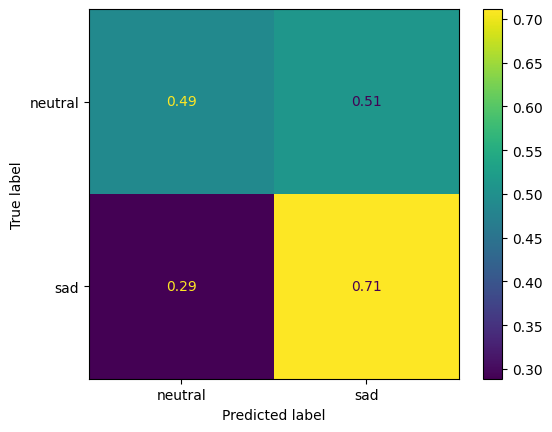

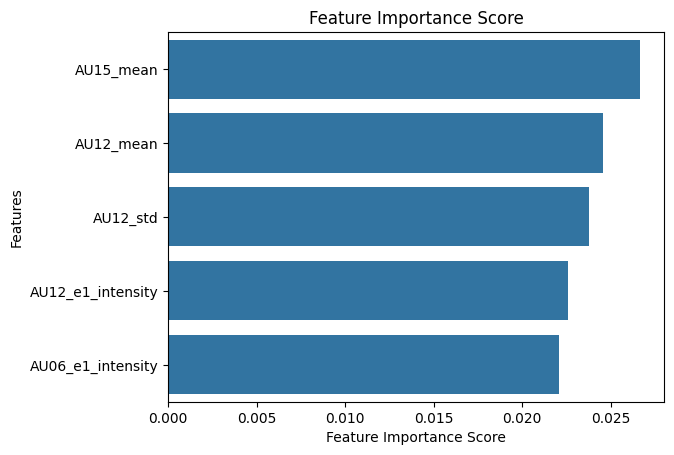

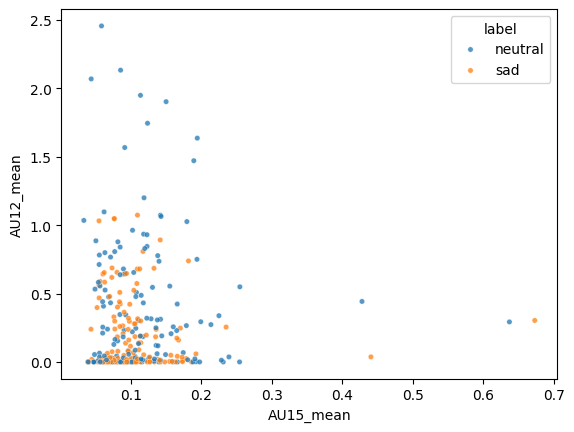

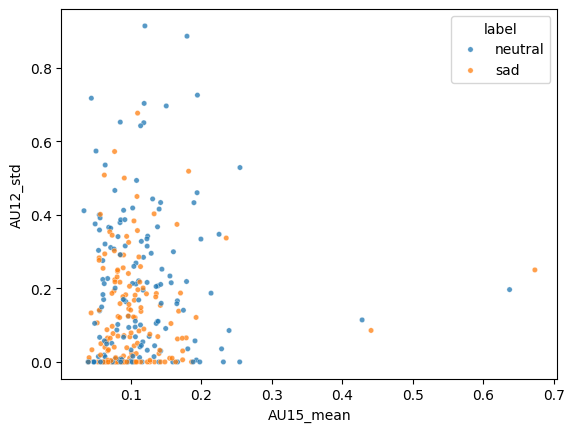

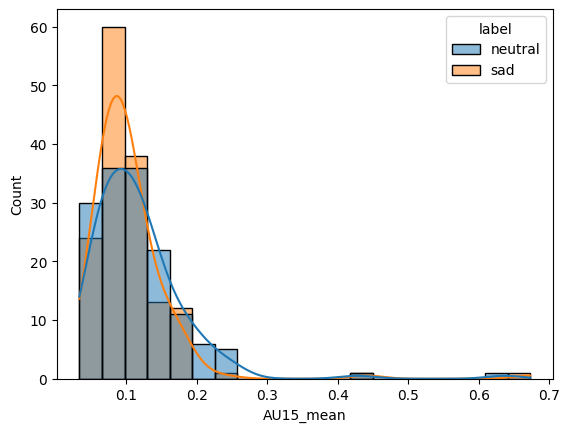

In [9]:
# xtrain = X_train[feature_imp[0:200].index.to_list()]
# xtest = X_test[feature_imp[0:200].index.to_list()]

xtrain = X_train
xtest = X_test

clf = RandomForestClassifier(criterion='entropy', max_depth=7)
clf.fit(xtrain, y_train)
feature_imp_ = pd.Series(clf.feature_importances_, index=df.columns.tolist()).sort_values(ascending=False)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f'f1: {f1_}')
print(f'prec: {prec}')
print(f'accuracy: {accuracy}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print('max_depth:', md)

plot_importance(feature_imp_)
scatter_imp_features(feature_imp_, 'label') # in Task2 change to 'label'
scatter_imp_features(feature_imp_, 'label',0,2)
hist_imp_features(feature_imp_, 'label',0)


              precision    recall  f1-score   support

     neutral       1.00      0.94      0.97       148
         sad       0.94      1.00      0.97       150

    accuracy                           0.97       298
   macro avg       0.97      0.97      0.97       298
weighted avg       0.97      0.97      0.97       298

f1: 0.9697574506951727
prec: 0.9716981132075472
max_depth: 7
121
AU02_std          0.034668
AU09_mean         0.033874
AU05_e2_length    0.023880
AU15_mean         0.023722
AU07_std          0.023672
dtype: float64


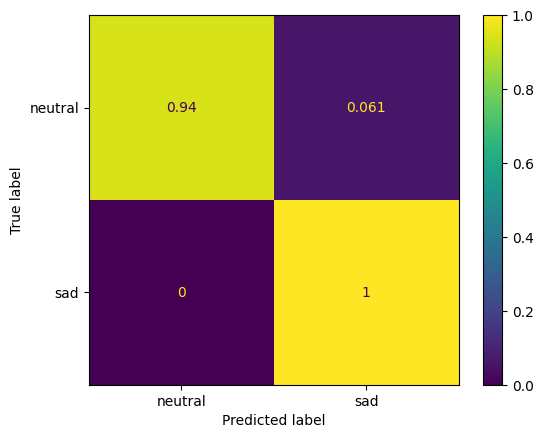

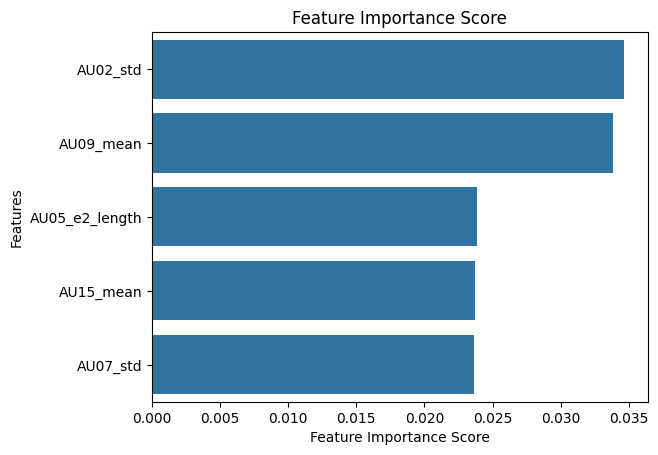

In [14]:
# overfit
md = 7
clf = RandomForestClassifier(criterion='entropy', max_depth=md)
clf.fit(df, labels)

y_pred = clf.predict(df)
print(classification_report(labels, y_pred, labels=clf.classes_))
f1_ = f1_score(labels, y_pred, average='macro')
prec = precision_score(labels, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(labels, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print('max_depth:', md)

feature_imp_ = pd.Series(clf.feature_importances_, index=df.columns.tolist()).sort_values(ascending=False)
plot_importance(feature_imp_)

100%|██████████| 25/25 [01:21<00:00,  3.24s/it]


features: 43 cv: 0.6906896551724138 


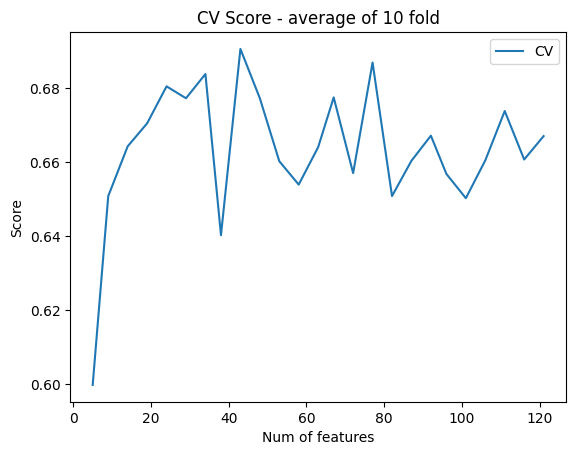

In [12]:
# cv score average per feature on the x -axis
from tqdm import tqdm
cv_aver = []
fe_range = np.linspace(5, 121, 25).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp_[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=11)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()

max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

# Tree

[Text(0.5909090909090909, 0.875, 'AU12_e1_intensity <= 1.054\nentropy = 1.0\nsamples = 298\nvalue = [148.0, 150.0]\nclass = neutral'),
 Text(0.36363636363636365, 0.625, 'AU01_e1_intensity <= 0.892\nentropy = 0.993\nsamples = 269\nvalue = [121, 148]\nclass = neutral'),
 Text(0.4772727272727273, 0.75, 'True  '),
 Text(0.18181818181818182, 0.375, 'AU09_std <= 0.126\nentropy = 0.999\nsamples = 250\nvalue = [120, 130]\nclass = neutral'),
 Text(0.09090909090909091, 0.125, 'entropy = 0.978\nsamples = 189\nvalue = [78, 111]\nclass = neutral'),
 Text(0.2727272727272727, 0.125, 'entropy = 0.895\nsamples = 61\nvalue = [42, 19]\nclass = sad'),
 Text(0.5454545454545454, 0.375, 'AU05_e0_intensity <= 0.059\nentropy = 0.297\nsamples = 19\nvalue = [1, 18]\nclass = neutral'),
 Text(0.45454545454545453, 0.125, 'entropy = 0.0\nsamples = 18\nvalue = [0, 18]\nclass = neutral'),
 Text(0.6363636363636364, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = sad'),
 Text(0.8181818181818182, 0.625, 'AU15

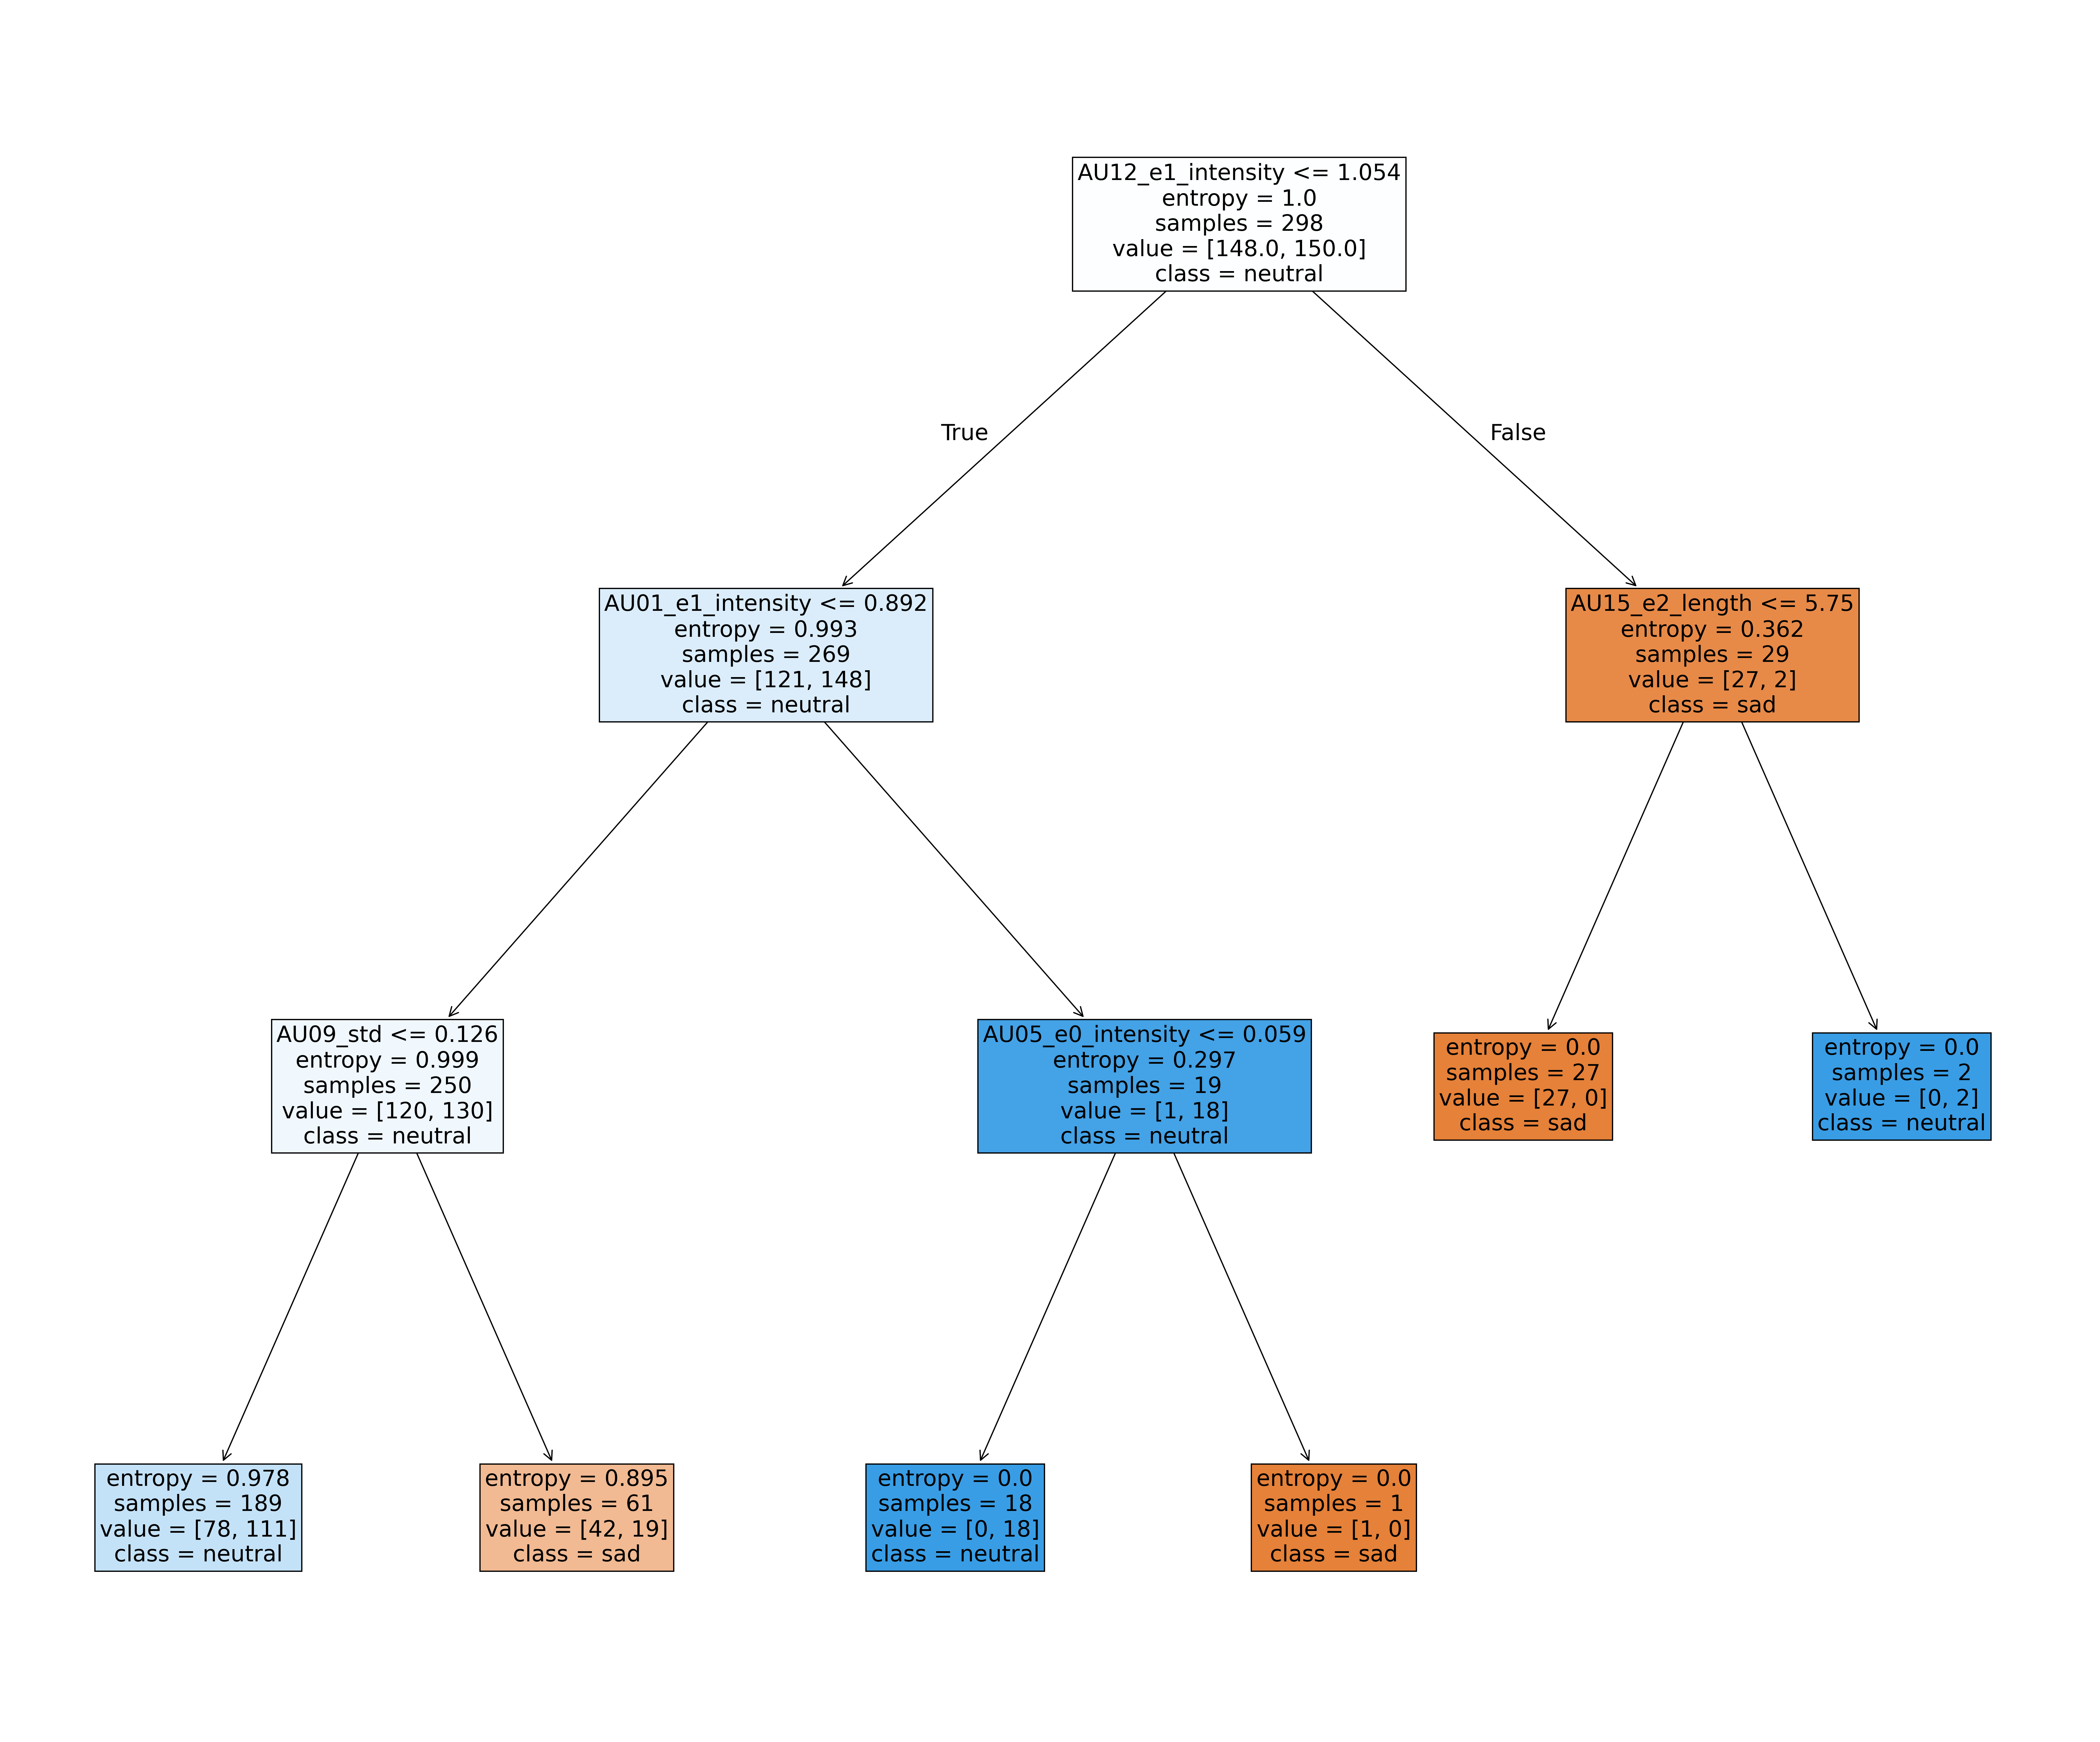

In [15]:
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, labels)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')